### Import necessary libraries

In [183]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import io
import sys
from urllib.request import urlopen
import requests
from PIL import Image, ImageStat
from io import BytesIO
from sklearn.cluster import KMeans
from scipy.spatial import KDTree
import webcolors
import pytesseract
import cv2
import math
import face_recognition
# !pip install dlib
import dlib
detector = dlib.get_frontal_face_detector()

In [77]:
df = pd.read_csv("merged_trending.csv")
df.describe()

,categoryId,view_count,likes,dislikes,comment_count,view_count_scaled,likes_scaled,dislikes_scaled
count,701004.000000,7.010040e+05,7.010040e+05,701004.000000,7.010040e+05,7.010040e+05,7.010040e+05,7.010040e+05
mean,19.002860,2.390922e+06,1.212055e+05,1255.845603,9.346914e+03,1.844765e-17,6.243821e-18,1.329853e-17
std,6.580038,6.769684e+06,3.807484e+05,8409.702363,7.024008e+04,1.000001e+00,1.000001e+00,1.000001e+00
min,1.000000,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,-3.808609e-01,-3.400731e-01,-1.529784e-01
25%,17.000000,4.219585e+05,1.542000e+04,0.000000,1.052000e+03,-2.922920e-01,-2.782109e-01,-1.513316e-01
50%,20.000000,8.816760e+05,3.866200e+04,0.000000,2.465000e+03,-2.245989e-01,-2.175802e-01,-1.436744e-01
75%,24.000000,2.020924e+06,9.832100e+04,531.000000,5.961000e+03,-5.503029e-02,-6.008222e-02,-8.640142e-02
max,29.000000,2.777917e+08,1.602155e+07,879357.000000,6.738537e+06,4.159494e+01,4.383878e+01,1.106698e+02


In [184]:
df["thumbnail_link"]
#701004 rows 

#Check if there are NA values --> No NAs found 
df["thumbnail_link"].isna().sum()

# Save urls to a list for later analysis 
thumbnails = df["thumbnail_link"]

#### Increase resolution and size of images 

In [185]:
#Add "mq" in front of "default" in url
mq_thumbnail_urls = [url.replace('default.jpg', 'mqdefault.jpg') for url in thumbnails]

# # Now mq_thumbnail_urls contains the modified URLs
mq_thumbnail_urls;

#Create sample set 
sample = mq_thumbnail_urls[0:30]

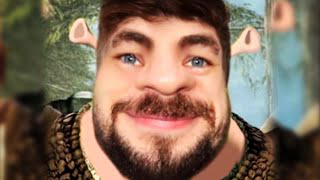

In [186]:
# Try retrieving image from url and raise error is image does not exist
def get_image(url):
    response = requests.get(url)
    if response.status_code == 200:
        return Image.open(BytesIO(response.content))
    else:
        return "None"

get_image(sample[2])

### a) Categorize the color palette in images

#### Set up dataframe to compile sample set

In [187]:
sample_df = pd.DataFrame(sample, columns=['url'])

In [188]:
# Validate image in url 
def get_image_from_url(url):
    try:
        response = requests.get(url, stream=True)
        response.raise_for_status() 

        # Only proceed if the content type is an image
        if 'image' in response.headers.get('Content-Type', ''):
            image = Image.open(BytesIO(response.content))
            return image
        else:
            return None
    except requests.HTTPError as e:
        return None
    except requests.RequestException as e:
        return None
    except Exception as e:
        return None

# Remove black headers and footers from image
def trim_black_borders(image):
    # Convert the image to grayscale 
    grey_image = image.convert('L')
    
    bw = grey_image.point(lambda x: 0 if x<10 else 255, '1')
    bbox = bw.getbbox()
    
    if bbox:
        # Crop the image to the contents of the bounding box
        image = image.crop(bbox)
    
    return image

# After several iterations of image size and cluster size, mq size and k=2 was determined to have the best results 
def get_dominant_color(image, k=2):
    # Convert image to numpy array and reshape to get RGP values
    image_np = np.array(image)
    image_np = image_np.reshape((-1, 3))

    # kmeans = KMeans(n_clusters=k, n_init=10)
    # kmeans.fit(image_np)
    # dominant_color = kmeans.cluster_centers_[0]
    # return tuple(dominant_color.astype(int))
    
    # # Fit Kmeans to find significant clusters 
    kmeans = KMeans(n_clusters=k, n_init=10, random_state=42)
    kmeans.fit(image_np)

    # Get colors and counts, and sort them to find the most dominant color
    unique, counts = np.unique(kmeans.labels_, return_counts=True)
    largest_cluster_index = unique[np.argmax(counts)]
    dominant_color = kmeans.cluster_centers_[largest_cluster_index]

    # Return RGB tuple
    return tuple(dominant_color.astype(int))

# Get RGB values to get the nearest human-readble color from Webcolors library
def convert_rgb_to_names(rgb_tuple):
    css3_db = webcolors.CSS3_HEX_TO_NAMES

    # Create list of RGB values 
    names = []
    rgb_values = []
    for color_hex, color_name in css3_db.items():
        names.append(color_name)
        rgb_values.append(webcolors.hex_to_rgb(color_hex))

    # Build KD tree to get the nearest color 
    kdt_db = KDTree(rgb_values)
    distance, index = kdt_db.query(rgb_tuple)
    return names[index]
    
sample_df['color_category'] = sample_df['url'].apply(lambda url: convert_rgb_to_names(get_dominant_color(trim_black_borders(get_image_from_url(url)))) if get_image_from_url(url) is not None else 'None')
sample_df.head()


,url,color_category
0,https://i.ytimg.com/vi/3C66w5Z0ixs/mqdefault.jpg,lightgray
1,https://i.ytimg.com/vi/M9Pmf9AB4Mo/mqdefault.jpg,black
2,https://i.ytimg.com/vi/J78aPJ3VyNs/mqdefault.jpg,darkolivegreen
3,https://i.ytimg.com/vi/kXLn3HkpjaA/mqdefault.jpg,darkolivegreen
4,https://i.ytimg.com/vi/VIUo6yapDbc/mqdefault.jpg,tan


### b) Measure the brightness, saturation, and contrast in images

#### Brightness

In [189]:
def pixel_brightness(pixel):
    r, g, b = pixel
    return math.sqrt(0.299 * r ** 2 + 0.587 * g ** 2 + 0.114 * b ** 2)

def image_brightness(img):
    #Check if the image is None
    if img is None:  
        return "None"
        
    img_array = np.array(img)
    # Apply the brightness formula to the entire array
    brightness = np.sqrt(0.299 * img_array[:,:,0]**2 + 0.587 * img_array[:,:,1]**2 + 0.114 * img_array[:,:,2]**2)
    
    return np.mean(brightness)

sample_df['brightness'] = sample_df['url'].apply(lambda url: image_brightness(get_image_from_url(url)))
sample_df.head()


,url,color_category,brightness
0,https://i.ytimg.com/vi/3C66w5Z0ixs/mqdefault.jpg,lightgray,10.133695
1,https://i.ytimg.com/vi/M9Pmf9AB4Mo/mqdefault.jpg,black,8.994039
2,https://i.ytimg.com/vi/J78aPJ3VyNs/mqdefault.jpg,darkolivegreen,9.906922
3,https://i.ytimg.com/vi/kXLn3HkpjaA/mqdefault.jpg,darkolivegreen,9.301224
4,https://i.ytimg.com/vi/VIUo6yapDbc/mqdefault.jpg,tan,9.547397


After going through the values for brightness, the values don't really tell us good information about the pictures. The difference in the values is also hard to intrepret when checking the images manually. **Proposing to drop brightness as a final feature**

In [190]:
sample_df.drop("brightness", axis=1, inplace=True);

#### Saturation

In [191]:
def measure_saturation(img):
    if img is None:
        return "None"

    img_array = np.array(img)
    
    # Convert RGB to BGR format for OpenCV
    img_array = img_array[:, :, ::-1]

    hsv = cv2.cvtColor(img_array, cv2.COLOR_RGB2HSV)

    # Extract the Saturation channel
    saturation_channel = hsv[:, :, 1]  
    
    # Get average of saturation values 
    avg_saturation = np.mean(saturation_channel)
    return avg_saturation

sample_df['saturation'] = sample_df['url'].apply(lambda url: measure_saturation(get_image_from_url(url)))
sample_df.head()


,url,color_category,saturation
0,https://i.ytimg.com/vi/3C66w5Z0ixs/mqdefault.jpg,lightgray,66.007135
1,https://i.ytimg.com/vi/M9Pmf9AB4Mo/mqdefault.jpg,black,156.426632
2,https://i.ytimg.com/vi/J78aPJ3VyNs/mqdefault.jpg,darkolivegreen,107.914097
3,https://i.ytimg.com/vi/kXLn3HkpjaA/mqdefault.jpg,darkolivegreen,90.338368
4,https://i.ytimg.com/vi/VIUo6yapDbc/mqdefault.jpg,tan,106.653698


#### Contrast

In [192]:
def measure_contrast(image):
    if image is None:
        return "None"

    # Convert the image to grayscale
    gray_image = image.convert('L')
    gray_array = np.array(gray_image)
    
    # Calculate the standard deviation to measure contrast
    contrast = np.std(gray_array)
    return contrast

sample_df['contrast'] = sample_df['url'].apply(lambda url: measure_contrast(get_image_from_url(url)))
sample_df.head()


,url,color_category,saturation,contrast
0,https://i.ytimg.com/vi/3C66w5Z0ixs/mqdefault.jpg,lightgray,66.007135,44.908509
1,https://i.ytimg.com/vi/M9Pmf9AB4Mo/mqdefault.jpg,black,156.426632,71.49472
2,https://i.ytimg.com/vi/J78aPJ3VyNs/mqdefault.jpg,darkolivegreen,107.914097,66.419014
3,https://i.ytimg.com/vi/kXLn3HkpjaA/mqdefault.jpg,darkolivegreen,90.338368,71.306497
4,https://i.ytimg.com/vi/VIUo6yapDbc/mqdefault.jpg,tan,106.653698,68.693131


### c) Detect if there are human faces in images

In [193]:
# Replace 'default' with 'sddefault' in the YouTube thumbnail URL
def convert_to_sd(url):
    if 'default' in url:
        return url.replace('mqdefault', 'sddefault')
    return url

sample_df['sd_thumbnail_url'] = sample_df['url'].apply(convert_to_hq)

# def detect_face(img):
#     if img is None:
#         return "None"
    
#     img_array = np.array(img.convert('RGB'))

#     # Use face_recognition to detect faces
#     face_locations = face_recognition.face_locations(img_array)
#     return 1 if len(face_locations) > 0 else 0

# def detect_face_dlib(img):
#     if img is None:
#         return "None"
            
#     # Convert PIL image to grayscale for dlib
#     gray = np.array(img.convert('L'))
#     faces = detector(gray, 1)
#     return 1 if len(face_locations) > 0 else 0
    
def detect_face_opencv(img):
    if img is None:
        return "None"
        
    # Convert PIL image to grayscale for Haar cascade
    gray = cv2.cvtColor(np.array(img), cv2.COLOR_BGR2GRAY)
    face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
    faces = face_cascade.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=5)
    return 1 if len(faces) > 0 else 0

# Now you can use 'sd_thumbnail_url' for the face detection
sample_df['face_detected'] = sample_df['sd_thumbnail_url'].apply(lambda url: detect_face_opencv(get_image_from_url(url)))
sample_df.head()


,url,color_category,saturation,contrast,sd_thumbnail_url,face_detected
0,https://i.ytimg.com/vi/3C66w5Z0ixs/mqdefault.jpg,lightgray,66.007135,44.908509,https://i.ytimg.com/vi/3C66w5Z0ixs/sddefault.jpg,1
1,https://i.ytimg.com/vi/M9Pmf9AB4Mo/mqdefault.jpg,black,156.426632,71.49472,https://i.ytimg.com/vi/M9Pmf9AB4Mo/sddefault.jpg,1
2,https://i.ytimg.com/vi/J78aPJ3VyNs/mqdefault.jpg,darkolivegreen,107.914097,66.419014,https://i.ytimg.com/vi/J78aPJ3VyNs/sddefault.jpg,1
3,https://i.ytimg.com/vi/kXLn3HkpjaA/mqdefault.jpg,darkolivegreen,90.338368,71.306497,https://i.ytimg.com/vi/kXLn3HkpjaA/sddefault.jpg,1
4,https://i.ytimg.com/vi/VIUo6yapDbc/mqdefault.jpg,tan,106.653698,68.693131,https://i.ytimg.com/vi/VIUo6yapDbc/sddefault.jpg,1


From the existing face detection libraries, **OpenCV** gave the best performance after manually checking the results

### d) Detect if there is text in the image

In [194]:
def detect_text(img):
    if img is None:
        return "None"
        
    img_array = np.array(img)

    # Convert to grayscale
    gray = cv2.cvtColor(img_array, cv2.COLOR_RGB2GRAY)

    # Use pytesseract to detect text
    text = pytesseract.image_to_string(gray, lang='eng')
    return 1 if text.strip() else 0

sample_df['text_detection'] = sample_df['url'].apply(lambda url: detect_text(get_image_from_url(url)))
sample_df.head()

,url,color_category,saturation,contrast,sd_thumbnail_url,face_detected,text_detection
0,https://i.ytimg.com/vi/3C66w5Z0ixs/mqdefault.jpg,lightgray,66.007135,44.908509,https://i.ytimg.com/vi/3C66w5Z0ixs/sddefault.jpg,1,0
1,https://i.ytimg.com/vi/M9Pmf9AB4Mo/mqdefault.jpg,black,156.426632,71.49472,https://i.ytimg.com/vi/M9Pmf9AB4Mo/sddefault.jpg,1,1
2,https://i.ytimg.com/vi/J78aPJ3VyNs/mqdefault.jpg,darkolivegreen,107.914097,66.419014,https://i.ytimg.com/vi/J78aPJ3VyNs/sddefault.jpg,1,0
3,https://i.ytimg.com/vi/kXLn3HkpjaA/mqdefault.jpg,darkolivegreen,90.338368,71.306497,https://i.ytimg.com/vi/kXLn3HkpjaA/sddefault.jpg,1,0
4,https://i.ytimg.com/vi/VIUo6yapDbc/mqdefault.jpg,tan,106.653698,68.693131,https://i.ytimg.com/vi/VIUo6yapDbc/sddefault.jpg,1,0


### Generate columns for merged CSV

In [198]:
def convert_to_mq(url):
    if 'default' in url:
        return url.replace('default', 'mqdefault')
    return url
    
def convert_to_sd(url):
    if 'default' in url:
        return url.replace('default', 'sddefault')
    return url
    

In [199]:
# Apply the convert_to_sd function to modify the URLs for higher quality images
df['mq_thumbnail_url'] = df['thumbnail_link'].apply(convert_to_mq)
df['sd_thumbnail_url'] = df['thumbnail_link'].apply(convert_to_sd)                                            
